# Clustering Case Study: Customer Segmentation with K-Means -  Tier 3
***
This case study is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by the `yhat` blog. Please feel free to refer to the post for additional information, and solutions.

Structure of the mini-project:

1. **Sourcing and loading**
    * Load the data
    * Explore the data


2. **Cleaning, transforming and visualizing**
    * Data Wrangling: Exercise Set 1
        - Creating a matrix with a binary indicator for whether they responded to a given offer
        - Ensure that in doing so, NAN values are dealt with appropriately
    

3. **Modelling** 
    * K-Means clustering: Exercise Sets 2 and 3
        - Choosing K: The Elbow method
        - Choosing K: The Silhouette method
        - Choosing K: The Gap statistic method
    
    * Visualizing clusters with PCA: Exercise Sets 4 and 5


4. **Conclusions and next steps**
    * Conclusions
    * Other clustering algorithms (Exercise Set 6)

In [28]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
# sns.set_context("poster")

## 1. Sourcing and loading
### 1a. Load the data
The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [29]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)

/opt/anaconda3/envs/springboard/lib/python3.12/site-packages/openpyxl/worksheet/_read_only.py:85: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


### 1b. Explore the data

In [30]:
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [31]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

/opt/anaconda3/envs/springboard/lib/python3.12/site-packages/openpyxl/worksheet/_read_only.py:85: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## 2. Cleaning, transforming and visualizing
### 2a. Data Wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [32]:
#your turn
offer_responses = pd.pivot_table(data = df_transactions, index = 'customer_name', columns = 'offer_id', values = 'n', fill_value=0).reset_index()
with pd.option_context('display.max_columns', 35, 'display.width', 200):
    print(offer_responses)  

offer_id customer_name    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16   17   18   19   20   21   22   23   24   25   26   27   28   29   30   31   32
0                Adams  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0
1                Allen  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
2             Anderson  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
3               Bailey  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0
4                Baker  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0

## 3. Modelling 
### 3a. K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

#### 3ai. Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

**Hint:** the Elbow Method is discussed in part 2 of the Harvard Clustering lecture. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

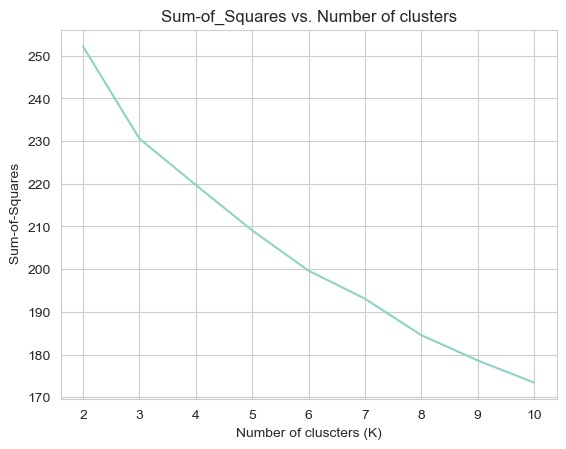

In [33]:
# your turn
from sklearn.cluster import KMeans

x_col = offer_responses.iloc[:, 1:].to_numpy()
metric = []
results = dict()

for k in range(2, 11):
    model = KMeans(n_clusters = k, random_state = 1812)
    model.fit(x_col)
    metric.append(model.inertia_)
    results[str(k)] = model.predict(x_col)

sns.lineplot(x = range(2, 11), y = metric)
plt.xlabel('Number of cluscters (K)')
plt.ylabel(' Sum-of-Squares')
plt.title('Sum-of_Squares vs. Number of clusters')
plt.show()

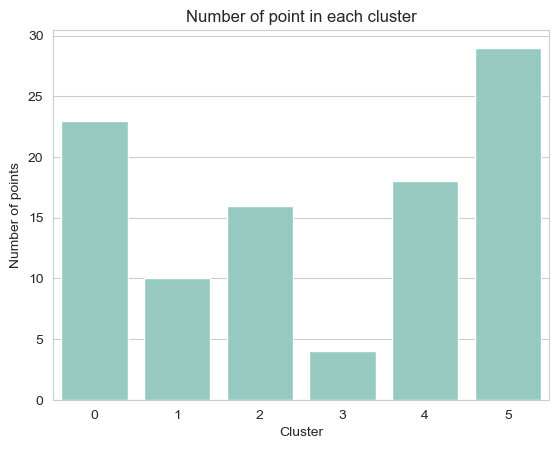

In [34]:
import numpy as np

my_K = 6
points_in_cluster = np.bincount(results[str(my_K)])

ax = sns.barplot(x = range(my_K), y = points_in_cluster)
ax.set(xlabel = 'Cluster', ylabel = 'Number of points', title = 'Number of point in each cluster')
plt.show()

<div class="alert alert-block alert-success">

__Answer:__  

There is no straightforward answer to the question of which SS (Sum of Squares) represents the best clustering. On the one hand, a lower SS indicates better clustering, as it shows that the samples are closer to their centroids. On the other hand, the smallest SS can be achieved when the number of clusters equals the number of samples — each sample becomes its own cluster, resulting in an SS of zero.

During this analysis, I encountered two main challenges:

1.	The SS (Sum of Squares) graph varies with each run due to the randomness in K-Means, leading to inconsistent decisions about the optimal number of clusters (K).
2.	In this case, the curve is relatively smooth and steadily decreasing, making it challenging to identify the best number of clusters (K).

Despite this, I chose 6 as the number of clusters, as the slope of the curve slightly decreases after this point.

</div>

#### 3aii. Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

**Hint**: Scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

For n_clusters = 2 The average silhouette_score is : 0.08911656187360473
For n_clusters = 3 The average silhouette_score is : 0.12015034646960629
For n_clusters = 4 The average silhouette_score is : 0.09868055986032757
For n_clusters = 5 The average silhouette_score is : 0.10880785100838314
For n_clusters = 6 The average silhouette_score is : 0.11486134519356281
For n_clusters = 7 The average silhouette_score is : 0.11367550102929376
For n_clusters = 8 The average silhouette_score is : 0.10740383079525533
For n_clusters = 9 The average silhouette_score is : 0.11828277646669702
For n_clusters = 10 The average silhouette_score is : 0.11326762330830306


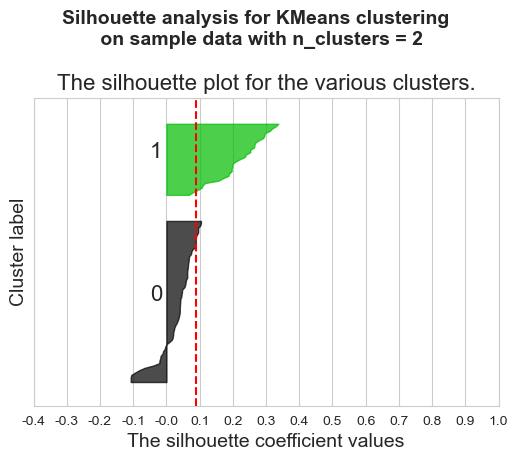

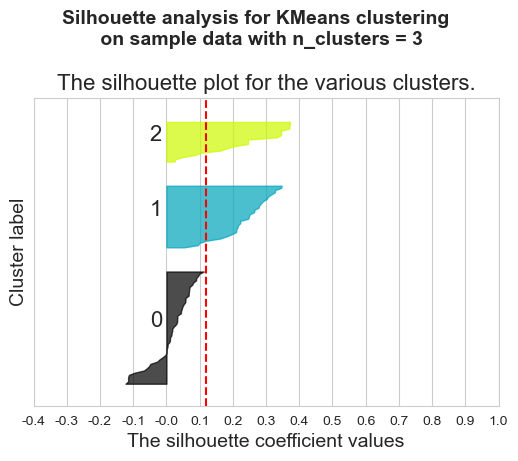

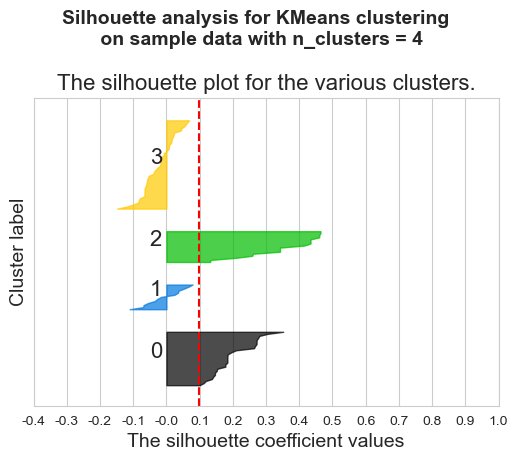

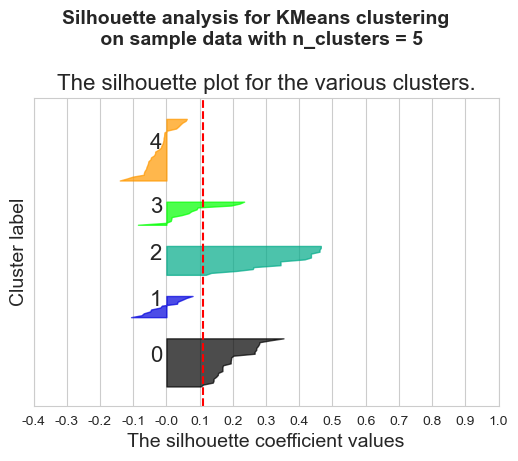

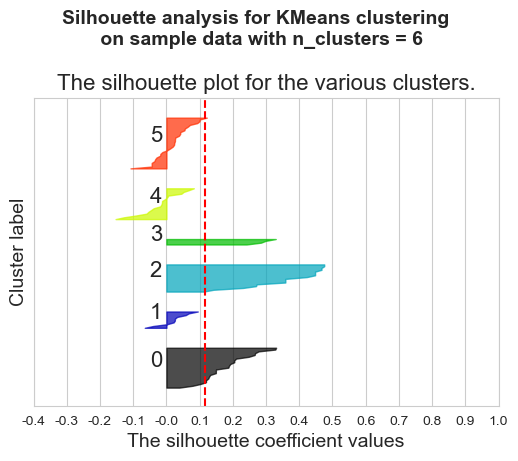

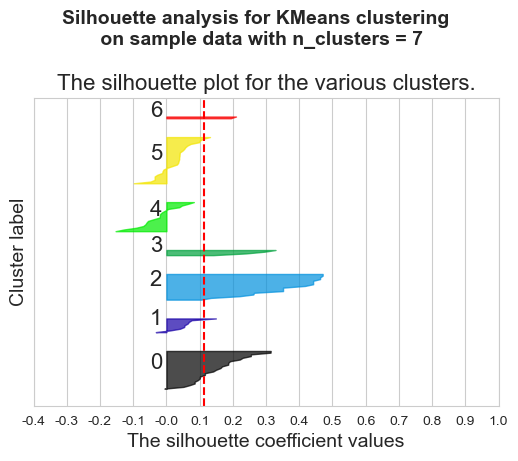

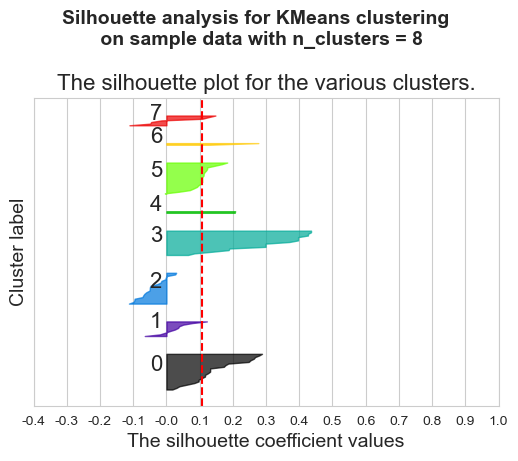

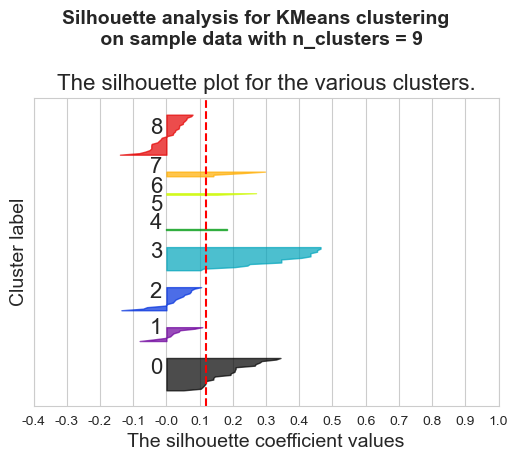

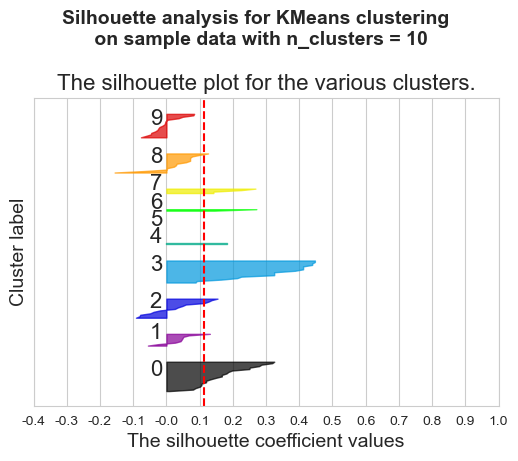

In [35]:
# Your turn.

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# The code was taken ftom the article (http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)
# and adapted
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score

range_n_clusters = range(2, 11)
sr = []

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, ax = plt.subplots()
    fig.set_size_inches(6, 4)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-1, 1]
    x_min_value = -0.4
    ax.set_xlim([x_min_value, 1])
    xticks = list(np.round(np.arange(x_min_value, 1.1, 0.1), 1))

    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(x_col) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    # clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    # cluster_labels = clusterer.fit_predict(X)
 
    cluster_labels = results[str(n_clusters)]
       

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(x_col, cluster_labels)
    sr.append(silhouette_avg)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x_col, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i), fontsize = 16)

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for the various clusters.", fontsize = 16)
    ax.set_xlabel("The silhouette coefficient values", fontsize = 14)
    ax.set_ylabel("Cluster label", fontsize = 14)

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks(xticks, labels=list(map(str, xticks)), fontsize=10)

    # 2nd Plot showing the actual clusters formed
    # colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    # ax2.scatter(
    #     X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    # )

    # Labeling the clusters
    # centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    # ax2.scatter(
    #     centers[:, 0],
    #     centers[:, 1],
    #     marker="o",
    #     c="white",
    #     alpha=1,
    #     s=200,
    #     edgecolor="k",
    # )

    # for i, c in enumerate(centers):
    #     ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    # ax2.set_title("The visualization of the clustered data.")
    # ax2.set_xlabel("Feature space for the 1st feature")
    # ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering \n on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
        y = 1.1
    )

plt.show()

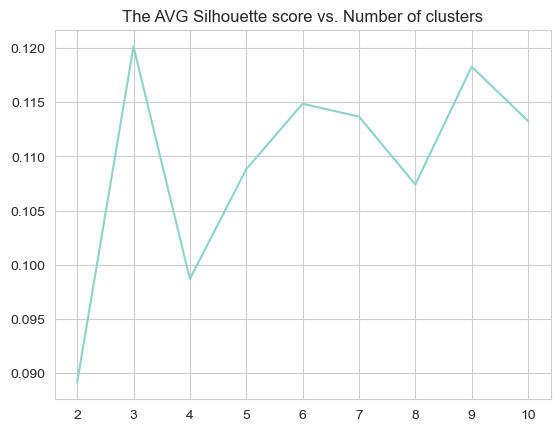

In [36]:
sns.lineplot(x = range_n_clusters, y = sr)
plt.title('The AVG Silhouette score vs. Number of clusters')
plt.show()

<div class="alert alert-block alert-success">
<b> Answer:</b>  

1.	All silhouette scores are quite low, with values significantly below 0.25. The highest average silhouette score is 0.12.
2.	Previously I selected K = 6 based on the Elbow method.
3.	However, the silhouette score plots suggest K = 3, with an average silhouette score of 0.12, as the optimal choice.
</div>

#### 3aiii.  Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

#### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

**Hint:** See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

### 3b. Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

**Hint:** PCA was discussed in the previous subunit. If you need help with it, consult [this useful article](https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c) and [this visual explanation](http://setosa.io/ev/principal-component-analysis/). 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

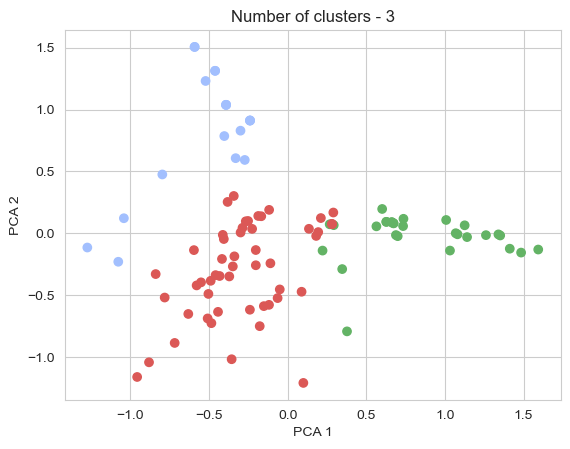

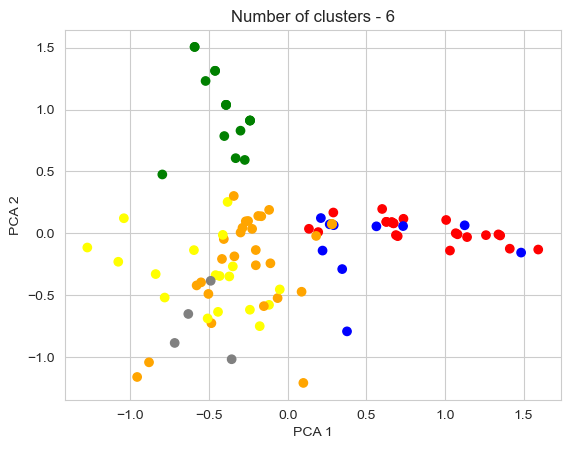

In [37]:
#your turn
from sklearn.decomposition import PCA
import matplotlib.colors as colors

model_3 = KMeans(n_clusters = 3, random_state = 1812)
clusters_predicted_3 = model_3.fit_predict(x_col)

model_6 = KMeans(n_clusters = 6, random_state = 1812)
clusters_predicted_6 = model_6.fit_predict(x_col)

pca_model = PCA(n_components=2)
pca_results = pca_model.fit_transform(x_col)
pca_1 = pca_results[:, 0]
pca_2 = pca_results[:, 1]

plt.scatter(pca_1, pca_2, c = clusters_predicted_3, cmap = colors.ListedColormap(['xkcd:pastel red', 'xkcd:boring green', 'xkcd:pastel blue']))
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Number of clusters - 3')
plt.show()

plt.scatter(pca_1, pca_2, c = clusters_predicted_6, cmap = colors.ListedColormap(['red', 'blue', 'green', 'grey', 'yellow', 'orange']))
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Number of clusters - 6')
plt.show()

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

In [38]:
# Adding clusters to the dataset with offer responses (rows are unique customers, columns are the offer_ids). The clusters are assigned to the customer names. 
offer_responses_ = pd.DataFrame()
offer_responses_ = offer_responses.set_index('customer_name')
offer_responses_['cluster'] = clusters_predicted_3

# Merging transactions with clusters and offers 
enreached_transactions = pd.merge(left = df_transactions, right = offer_responses_['cluster'], left_index=False, left_on='customer_name', right_index=True)
enreached_transactions = pd.merge(left = enreached_transactions, right = df_offers, left_index=False, left_on='offer_id', right_index=False, right_on='offer_id')

In [39]:
# The median minimal quantities and discounts for each cluster
enreached_transactions.groupby(by='cluster')[['min_qty', 'discount']].agg('median')

,min_qty,discount
cluster,,
0,72.0,63.0
1,6.0,50.0
2,72.0,52.0


In [40]:
# Getting the number of customers per cluster per offer
enreached_offer = pd.crosstab(columns=enreached_transactions['cluster'], index=enreached_transactions['offer_id'])
# Adding information from the original data about offers
enreached_offer = pd.merge(left = enreached_offer, right=df_offers.set_index(['offer_id']), left_index=True, right_index=True)

# Printing the top-5 in each cluster with all detail from the original offer dataset
for i in range(3):
    with pd.option_context('display.width', 100):
        print('-' * 100)
        print(enreached_offer.sort_values(by=i, ascending=False).head())

----------------------------------------------------------------------------------------------------
           0  1  2  campaign   varietal  min_qty  discount  origin  past_peak
offer_id                                                                     
22        19  1  1    August  Champagne       72        63  France      False
31        17  0  0  December  Champagne       72        89  France      False
11        11  0  2       May  Champagne       72        85  France      False
6         10  1  1     March   Prosecco      144        86   Chile      False
4          9  0  3  February  Champagne       72        48  France       True
----------------------------------------------------------------------------------------------------
          0   1  2  campaign      varietal  min_qty  discount        origin  past_peak
offer_id                                                                              
30        6  16  0  December        Malbec        6        54        France   

<div class="alert alert-block alert-success" >

__Answer:__  

1.	Considering the PCA graphs, clustering with 3 clusters appears more logical than clustering with 6. The choice of 3 clusters was supported by the Silhouette score method.
2.	In the context of the original data, we observe the following:
    *   Customers assigned to cluster 0 preferred Champagne and purchased it in relatively large quantities.
    *	Customers in cluster 2 primarily bought Pinot Noir in quantities similar to those in cluster 0.
    *	Customers in cluster 1 purchased a variety of items in relatively smaller quantities compared to clusters 0 and 2.

</div>

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

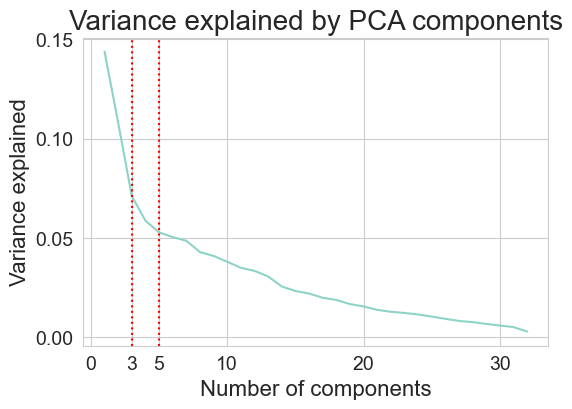

In [41]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(x_col)


# Do the rest on your own :)
fig, ax = plt.subplots()
fig.set_size_inches(6, 4)
ax = sns.lineplot(x = list(range(1, 33)), y = pca.explained_variance_ratio_)
ax.set_ylabel('Variance explained', fontsize = 16)
ax.set_xlabel('Number of components', fontsize = 16)
plt.xticks([0, 3, 5, 10, 20, 30], fontsize = 14)
plt.yticks([0, 0.05, 0.10, 0.15], fontsize = 14)
plt.axvline(3, c = 'red', linestyle = 'dotted')
plt.axvline(5, c = 'red', linestyle = 'dotted')
plt.title('Variance explained by PCA components', fontsize = 20)
plt.show()

<div class="alert alert-block alert-success">

__Answer:__

1.	The graph of the explained variance indicates that the optimal number of dimensions lies between 3 and 5. This is because the graph displays an ‘elbow’ in this range—a noticeable change in the slope of the line, signifying a diminishing return in the variance explained as additional components are added.

</div>

## 4. Conclusions and next steps
### 4a. Conclusions
What can you conclude from your investigations? Make a note, formulate it as clearly as possible, and be prepared to discuss it with your mentor in your next call. 

### 4b. Other clustering algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>

Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


### DBSCAN

Choosing the best hyperparameters for DBSCAN model - method #1

In [42]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from itertools import product

# Parameter grid
eps_values = np.linspace(1, 3.2, 221)
min_samples_values = range(2, 50)

# Metrics variables
best_params = {'eps': None, 'min_samples': None}
best_results = {'n_clusters': None, 'noise': None}
best_score = -np.inf

# Let's go through all possible combinations of parameters
for eps, min_samples in product(eps_values, min_samples_values):
    dbscan_model = DBSCAN(eps = eps, min_samples = min_samples)
    labels_predicted = dbscan_model.fit_predict(x_col)

    n_clusters = len(set(labels_predicted)) - (1 if -1 in labels_predicted else 0)  # Number of clusters without cluster labeled -1
    noise = list(labels_predicted).count(-1)

    if n_clusters > 1:
        score = silhouette_score(x_col, labels_predicted)
        if score > best_score:
            best_score = score
            best_params['eps'] = eps
            best_params['min_samples'] = min_samples
            best_results['n_clusters'] = n_clusters
            best_results['noise'] = noise
            best_labels = labels_predicted
            

print(f'Best parameters: {best_params}')
print(f'Best results: {best_results}')
print(f'Best score: {best_score}')

Best parameters: {'eps': 1.42, 'min_samples': 2}
Best results: {'n_clusters': 3, 'noise': 28}
Best score: 0.09500391877093202


Choosing the best hyperparameters for DBSCAN model - method #2

In [43]:

from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV

# Custom scorer
def dbscan_silhouette_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    if len(set(labels)) - (1 if -1 in labels else 0) > 1:
        return silhouette_score(X, labels)
    else:
        return -1  
    
    
# Gris Search hyperparameters
param_grid = {'eps': np.linspace(1, 3.2, 221), 'min_samples': range(2, 10)}
dbs_model = DBSCAN()
grid_search = GridSearchCV(dbs_model, param_grid, scoring=dbscan_silhouette_scorer, cv=[(slice(None), slice(None))])

grid_search.fit(x_col)
labels_predicted = grid_search.best_estimator_.fit_predict(x_col)
n_clusters = len(set(labels_predicted)) - (1 if -1 in labels_predicted else 0)
noise = list(grid_search.best_estimator_.fit_predict(x_col)).count(-1)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)
print(f'Best results: n_clusters = {n_clusters}, noise = {noise}')

Best Parameters: {'eps': 1.42, 'min_samples': 2}
Best Score: 0.09500391877093202
Best results: n_clusters = 3, noise = 28


<div class='alert alert-block alert-success'>

__Comment:__
The best result of the DBSCAN method has esp = 1.42, min_sanples = 2 as hyperparameters and produced 3 clusters, with 28 points remaining unassigned to any cluster.
</div>

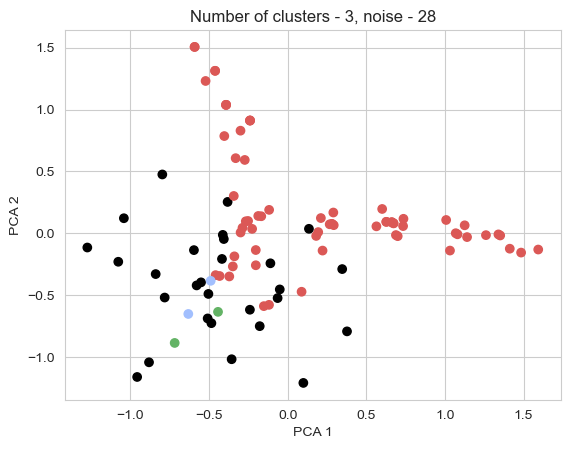

In [44]:
db = DBSCAN(eps= 1.42, min_samples= 2)

labels_DBSCAN = db.fit_predict(x_col)
labels_DBSCAN[labels_DBSCAN == -1] = 3
ax = plt.scatter(pca_1, pca_2, c = labels_DBSCAN, cmap = colors.ListedColormap(['xkcd:pastel red', 'xkcd:boring green', 'xkcd:pastel blue', 'black']))
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Number of clusters - 3, noise - 28')
plt.show()


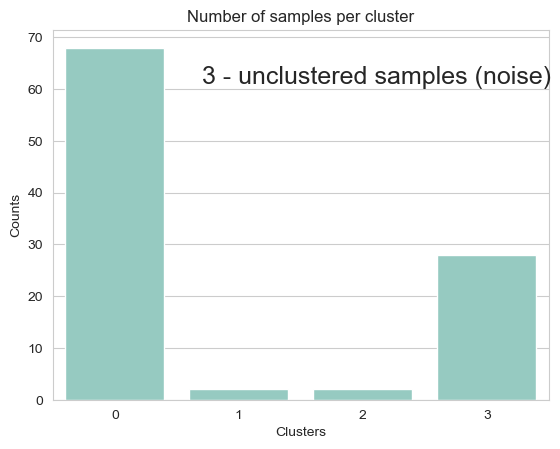

Score: 0.09500391877093202


In [45]:
sns.countplot(x = list(labels_DBSCAN))
plt.xlabel('Clusters')
plt.ylabel('Counts')
plt.title('Number of samples per cluster')
plt.text(0.7,61, '3 - unclustered samples (noise)', fontsize = 18)
plt.show()
print("Score:", silhouette_score(x_col, labels_DBSCAN))

<div class='alert alert-success'>

__Comment:__ The visualizations above illustrate how the DBSCAN clustering results are distributed across the two PCA axes. It appears that the method could not cluster the remaining unassigned points due to their large distances. However, this could be a reasonable decision from a business perspective—it might be preferable to leave some observations unclustered rather than artificially assigning them to a cluster.

Additionally, the ‘0’ cluster (red points) warrants further discussion. Its upper-left samples are significantly distant from the rightmost points but belong to the same cluster because they are indirectly connected. From a business perspective, this clustering decision may be questionable. In terms of the two most important factors (PCA-1 and PCA-2), these points could differ significantly from each other.
</div>

### Agglomerative clustering


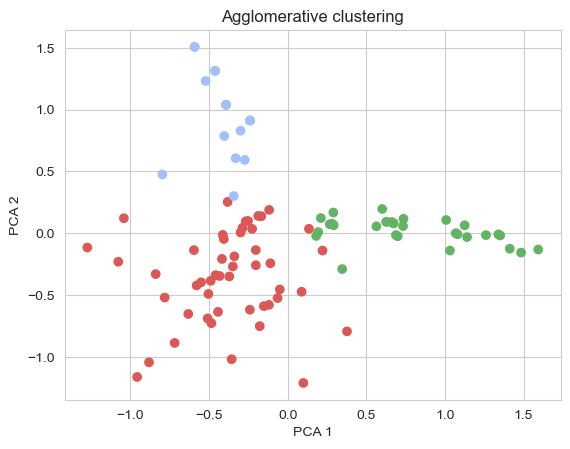

In [46]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(n_clusters = 3).fit(x_col)
labels_Agglomerative = clustering.labels_

ax = plt.scatter(pca_1, pca_2, c = labels_Agglomerative, cmap = colors.ListedColormap(['xkcd:pastel red', 'xkcd:boring green', 'xkcd:pastel blue', ]))
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Agglomerative clustering')
plt.show()

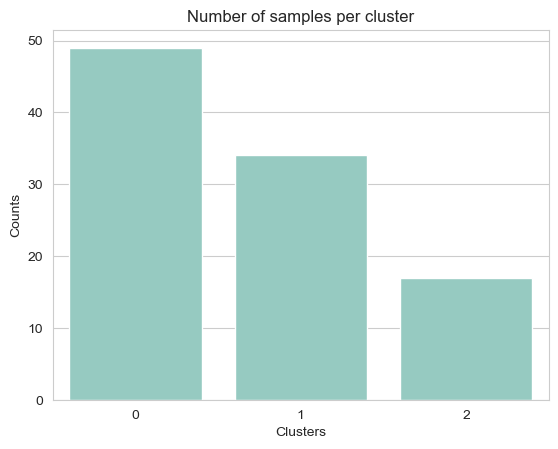

Score: 0.11625878863607858


In [47]:
sns.countplot(x = list(labels_Agglomerative))
plt.xlabel('Clusters')
plt.ylabel('Counts')
plt.title('Number of samples per cluster')
plt.show()

print('Score:', silhouette_score(x_col, labels_Agglomerative))

<div class='alert alert-block alert-success'>

__Comment:__ The results of the Agglomerative Clustering method are very similar to those of the KMeans method. Visually, they appear reasonable. The Silhouette Score is still quite low, but it is comparable to the score obtained for KMeans and DBSCAN clusterings above.
</div>

### Affinity Propagation

In [48]:
from sklearn.cluster import AffinityPropagation

param_grid = {'preference': range(-110, -23, 1)}  # Tge absolute value for minimal value of 'preference' set higher than the number of points 
                                                # (in our case the number of points is 100)
                                                
# Custom scorer
def ap_silhouette_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    if len(set(labels)) > 1:
        return silhouette_score(X, labels)
    else:
        return -1  
    
ap_model = AffinityPropagation(random_state=1812)
grs_model = GridSearchCV(ap_model, param_grid, scoring=ap_silhouette_scorer, cv=[(slice(None), slice(None))])
grs_model.fit(x_col)

print("Best Parameters:", grs_model.best_params_)
print("Best Score:", grs_model.best_score_)

Best Parameters: {'preference': -34}
Best Score: 0.11589587363906113


In [49]:
from sklearn.cluster import AffinityPropagation

ap = AffinityPropagation(preference=-34, random_state=1812).fit(x_col)
ap_predict = ap.predict(x_col)
print('Number of clusters:', len(set(ap_predict)))


Number of clusters: 3


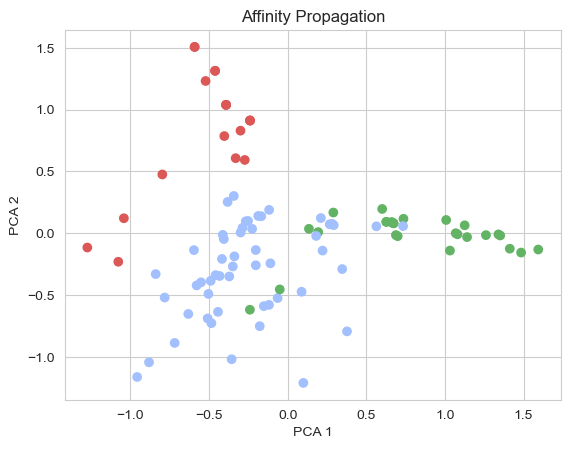

In [50]:
plt.scatter(pca_1, pca_2, c = ap_predict, cmap = colors.ListedColormap(['xkcd:pastel red', 'xkcd:boring green', 'xkcd:pastel blue', ]))
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Affinity Propagation')
plt.show()

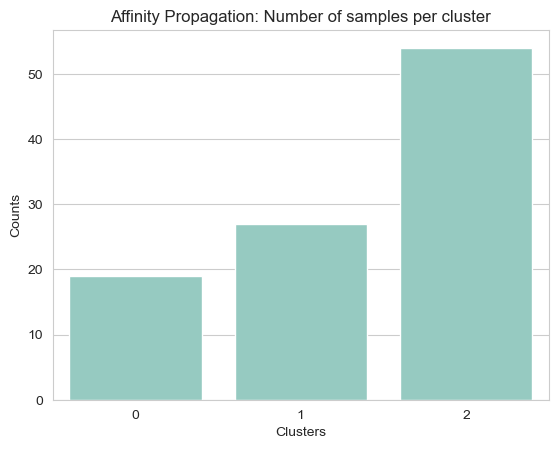

Score: 0.11589587363906113


In [51]:
sns.countplot(x = list(ap_predict))
plt.xlabel('Clusters')
plt.ylabel('Counts')
plt.title('Affinity Propagation: Number of samples per cluster')
plt.xticks(range(len(set(ap_predict))))
plt.show()

print('Score:', silhouette_score(x_col, ap_predict))

<div class='alert alert-block alert-success'>

__Comment:__ The visualization pattern of the Affinity Propagation clustering results on the two PCA dimensions is very similar to the results of the other methods discussed above. The Silhouette Score is also comparable at 0.1159. Notably, the optimal number of clusters is also 3, with a reasonably clear clustering pattern observed on the PCA dimensions graph.
</div>

### Spectral Clustering

In [52]:
from sklearn.cluster import SpectralClustering

param_grid = {'n_clusters': range(2, 10),
              'assign_labels' :['discretize', 'cluster_qr', 'kmeans'], 
              'random_state' : [1812]}
sc_model = SpectralClustering()
sc_gs_model = GridSearchCV(sc_model, param_grid, scoring=ap_silhouette_scorer, cv=[(slice(None), slice(None))])
sc_gs_model.fit(x_col)


print('Best parameters (number of clusters):', sc_gs_model.best_params_['n_clusters'])
print('Best score:', sc_gs_model.best_score_)
print(sc_gs_model.best_params_)

Best parameters (number of clusters): 3
Best score: 0.11326767881525888
{'assign_labels': 'discretize', 'n_clusters': 3, 'random_state': 1812}


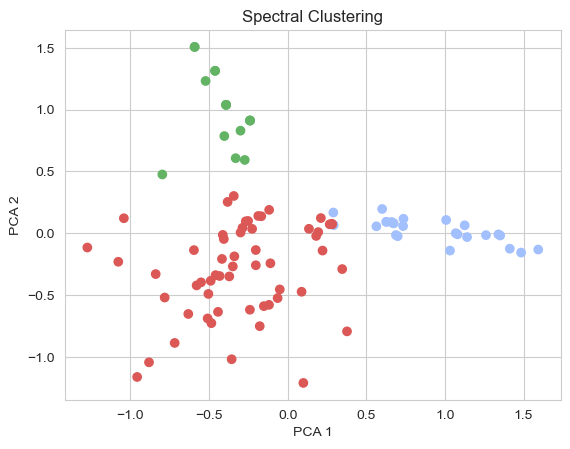

In [53]:
sc_model = SpectralClustering(n_clusters = 3, assign_labels='discretize', random_state=1812)
sc_labels = sc_model.fit_predict(x_col)

plt.scatter(pca_1, pca_2, c = sc_labels, cmap = colors.ListedColormap(['xkcd:pastel red', 'xkcd:boring green', 'xkcd:pastel blue', ]))
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Spectral Clustering')
plt.show()

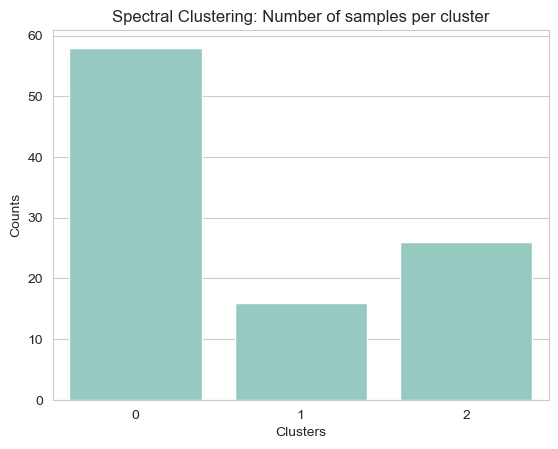

Score: 0.11326767881525888


In [54]:
sns.countplot(x = list(sc_labels))
plt.xlabel('Clusters')
plt.ylabel('Counts')
plt.title('Spectral Clustering: Number of samples per cluster')
plt.show()

print('Score:', silhouette_score(x_col, sc_labels))

<div class='alert alert-block alert-success'>

__Comment:__ The Spectral Clustering algorithm also achieves its best results with 3 clusters, producing a clustering pattern similar to that of the other methods, albeit with a slightly lower Silhouette Score of 0.1133.
</div>

<div class='alert alert-block alert-success'>  

__Conclusions:__  


1.	The clustering methods produced the following results:
    *	_KMeans:_ 3 clusters, Silhouette Score: 0.1202
    *	_DBSCAN:_ 3 clusters (28 samples unclustered), Silhouette Score: 0.0950
    *	_Agglomerative Clustering:_ 3 clusters, Silhouette Score: 0.1163
    *	_Affinity Propagation:_ 3 clusters, Silhouette Score: 0.1159
    *	_Spectral Clustering:_ 3 clusters, Silhouette Score: 0.1133

2.	Two algorithms (KMeans and Agglomerative Clustering) used 3 clusters as a predefined parameter. All other algorithms, despite not having a predefined number of clusters, also converged to 3 clusters. This consistency across methods suggests that 3 clusters may indeed be the optimal choice.  

3.	PCA analysis indicates that 3 to 5 principal components most effectively explain the variation between observations (in this case, 100 customers).  
4.	PCA was also employed to select the two most important components for visualizing clustering results. The clustering patterns observed in the visualizations were consistent across different methods.  
5.	Most methods produced similar results, with Silhouette Scores ranging narrowly between 0.1133 and 0.1202. The only exception was DBSCAN, which yielded a lower score of 0.0950. The best-performing method, based on the Silhouette Score, was KMeans.  
6.	In the context of the original data, using KMeans clustering, the following insights were observed:
    *	_Cluster 0:_ Customers primarily preferred Champagne, purchasing it in relatively large quantities.
    *	_Cluster 2:_ Customers predominantly bought Pinot Noir, with purchase quantities comparable to those in Cluster 0.
    *	_Cluster 1:_ Customers purchased a variety of items but in smaller quantities compared to Clusters 0 and 2.